# Density Estimation

In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import numpy as onp
from rbig_jax.data import get_classic

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

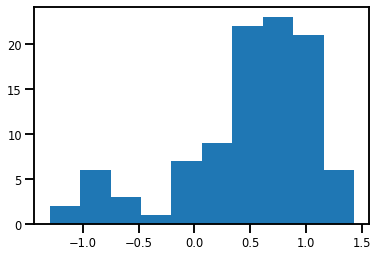

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

### Kernel

In [3]:
def expensive_kde(eval_points, samples, bandwidth):
    # distances
    rescaled_x = (eval_points[:, np.newaxis] - samples[np.newaxis, :]) / bandwidth
    
    # compute the gaussian kernel
    gaussian_kernel = np.exp(-0.5 * rescaled_x ** 2) / np.sqrt(2 * np.pi) / bandwidth
    
    # rescale
    return gaussian_kernel / samples.shape[0]

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


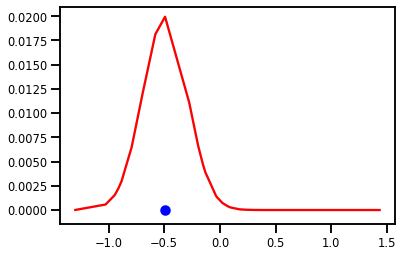

In [4]:
bw = 0.2

x = np.sort(data[:, 1])
xi = np.array([x[10]])


k = expensive_kde(xi, x, bw)

plt.plot(x, k.T, color='gray', alpha=0.3);
plt.plot(x, k.sum(axis=0), color='red');
plt.scatter(xi, np.zeros(xi.shape), color='blue')

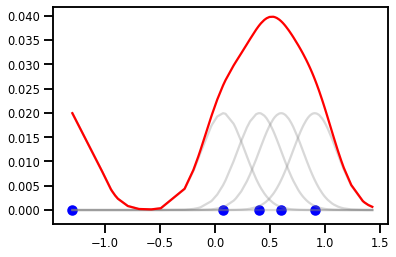

In [5]:
bw = 0.2

n_samples = 5

x = np.sort(data[:, 1])
xi = np.array(onp.random.choice(onp.array(x), n_samples))


k = expensive_kde(xi, x, bw)

plt.plot(x, k.T, color='gray', alpha=0.3);
plt.plot(x, k.sum(axis=0), color='red');
plt.scatter(xi, np.zeros(xi.shape), color='blue')

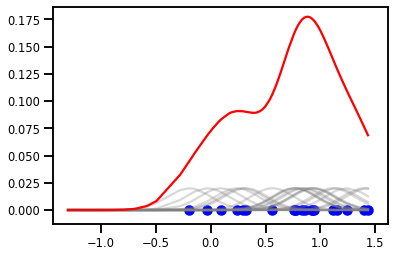

In [6]:
bw = 0.2

n_samples = 20

x = np.sort(data[:, 1])
xi = np.array(onp.random.choice(onp.array(x), n_samples))


k = expensive_kde(xi, x, bw)

plt.plot(x, k.T, color='gray', alpha=0.3);
plt.plot(x, k.sum(axis=0), color='red');
plt.scatter(xi, np.zeros(xi.shape), color='blue')

(50, 100) (100,) (50,)


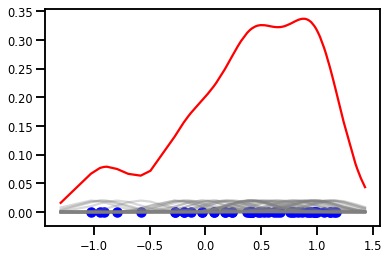

In [7]:
bw = 0.2

n_samples = 50

x = np.sort(data[:, 1])
xi = np.array(onp.random.choice(onp.array(x), n_samples))
xi = np.sort(xi)

k = expensive_kde(xi, x, bw)
print(k.shape, x.shape, xi.shape)
plt.plot(x, k.T, color='gray', alpha=0.3);
plt.plot(x, k.sum(axis=0), color='red');
plt.scatter(xi, np.zeros(xi.shape), color='blue')

## Benchmarks

### 1. Scipy Implementation

In [8]:
from scipy import stats

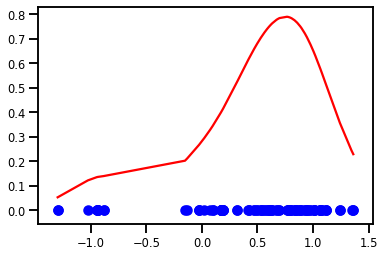

In [9]:
bw = 0.2

n_samples = 100

x = np.sort(data[:, 1])
xi = np.array(onp.random.choice(onp.array(x), n_samples))
xi = np.sort(xi)

kde_model = stats.gaussian_kde(onp.array(x))

k = kde_model.evaluate(onp.array(xi))

plt.plot(xi, k, color='red');
plt.scatter(xi, np.zeros(xi.shape), color='blue')

In [10]:
%timeit kde_model.evaluate(onp.array(x))

252 µs ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### 1. Expensive

This way is quite expensive because we will need to calculate a matrix that is `n_samples, n_evals`. This can be nasty for large datasets.

In [11]:
def broadcast_kde_pdf(eval_points, samples, bandwidth):
    
    # distances (use broadcasting)
    rescaled_x = (eval_points[:, np.newaxis] - samples[np.newaxis, :]) / bandwidth ** 2
    
    # compute the gaussian kernel
    gaussian_kernel = np.exp(-0.5 * rescaled_x ** 2) / np.sqrt(2 * np.pi) / bandwidth ** 2
    
    # rescale
    return gaussian_kernel.sum(axis=1) / samples.shape[0]

In [12]:
def scotts_method(n, d):
    return np.power(n, -1./(d+4))

def silvermans_method(n, d):
    return np.power(n*(d+2.0)/4.0, -1./(d+4))

In [13]:
bw

0.2

In [14]:
kde_model.factor, kde_model.covariance_factor(), kde_model.factor, kde_model.neff, kde_model._norm_factor

(0.3981071705534972,
 0.3981071705534972,
 0.3981071705534972,
 100.0,
 0.6022332916529493)

0.2
(100,)
(10000, 100)
(100,)
0.3981071705534972 0.3981071705534972 0.3981071705534972 100.0 0.6022332916529493
(10000,)


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


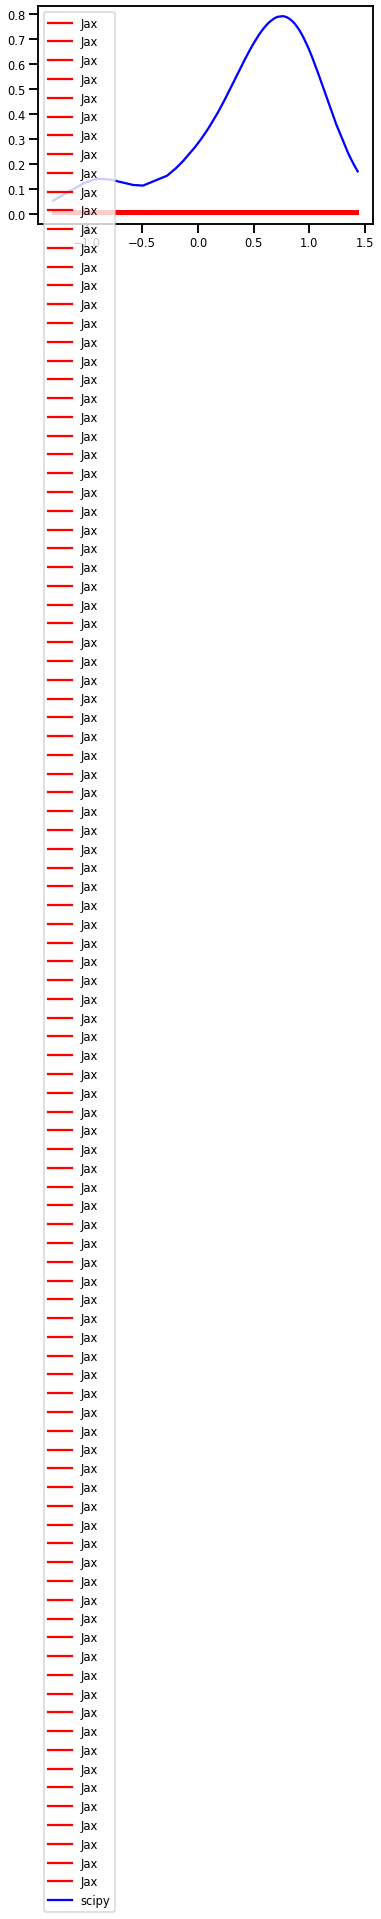

In [15]:

n_samples = 10000

print(bw)

x = np.sort(data[:, 1])
bw = scotts_method(x.shape[0], 1)
xi = np.array(onp.random.choice(onp.array(x), n_samples))
xi = np.sort(xi)

print(x.shape)
k = expensive_kde(xi, x, bw)
print(k.shape)

plt.plot(xi, k, color='red', label='Jax');

# SCIPY
print(x.shape)
kde_model = stats.gaussian_kde(onp.array(x), bw_method='scott')

print(kde_model.factor, kde_model.covariance_factor(), kde_model.factor, kde_model.neff, kde_model._norm_factor)
k_sci = kde_model.evaluate(onp.array(xi))
print(k_sci.shape)

plt.plot(xi, k_sci, color='blue', label='scipy');
# plt.scatter(xi, np.zeros(xi.shape), color='blue')
plt.legend()

In [18]:
exp_kde = jax.jit(expensive_kde)

In [19]:
%timeit expensive_kde(x, x, bw)

1.56 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
m = %memit -o expensive_kde(x, x, bw)

UsageError: Line magic function `%memit` not found.


In [21]:
@jax.jit
def batch_kde(eval_points, samples, bandwidth):
    
    # distances (use broadcasting)
    rescaled_x = (eval_points - samples) / bandwidth ** 2
    
    # compute the gaussian kernel
    gaussian_kernel = np.exp(-0.5 * rescaled_x ** 2) / np.sqrt(2 * np.pi) / bandwidth ** 2
    
    # rescale
    return gaussian_kernel.sum(axis=0) / samples.shape[0]

In [22]:
from functools import partial

batched_kde = jax.jit(jax.vmap(partial(batch_kde, bandwidth=bw, samples=x), in_axes=(0,)))


In [23]:
%timeit batched_kde(x)

173 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


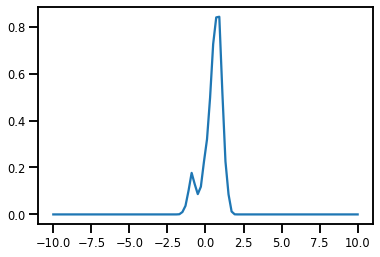

In [24]:

x_eval = np.linspace(-10.0, 10.0, 100)
x_pdf = batched_kde(x_eval)

plt.plot(x_eval, x_pdf)

In [25]:
t = %timeit -o batched_kde(x_eval)

115 µs ± 734 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
%load_ext memory_profiler

m = %memit -o batched_kde(x_eval)

peak memory: 313.29 MiB, increment: -4.06 MiB


In [27]:
m.mem_usage

[313.2890625]

In [28]:
t.average, t.stdev

(0.00011510765857362587, 7.34417912306593e-07)

In [29]:
import tqdm
n_samples = [10, 100, 1_000, 10_000, 1_000_000, 10_000_000]
times = {
    "jax_mu": list(),
    "jax_stdev": list(),
    "vmap_mu": list(),
    "vmap_stdev": list(),
}

memories = {
    "jax_mu": list(),
    "jax_stdev": list(),
    "vmap_mu": list(),
    "vmap_stdev": list(),
}

batched_kde = jax.jit(jax.vmap(partial(batch_kde, bandwidth=bw, samples=x), in_axes=(0,)))

broadcast_kde = jax.jit(partial(expensive_kde, samples=x, bandwidth=bw))

pbar = tqdm.tqdm(n_samples, desc="Samples")
with pbar:
    for isamples in pbar:

        # generate grid
        x_eval = np.linspace(-10.0, 10.0, isamples)
        
        # ==================
        # Jax Implementation
        # ==================

        # evaluate timings
        t = %timeit -o broadcast_kde(x_eval)
        m = %memit -o broadcast_kde(x_eval)

        # append times
        times['jax_mu'].append(t.average)
        times['jax_stdev'].append(t.stdev)
        
        # append memory usage
        memories['jax_mu'].append(m.mem_usage)
        
        # ==================
        # Vmap Implementation
        # ==================

        # evaluate timings
        t = %timeit -o batched_kde(x_eval)
        m = %memit -o batched_kde(x_eval)

        # append times
        times['vmap_mu'].append(t.average)
        times['vmap_stdev'].append(t.stdev)
        
        # append memory usage
        memories['vmap_mu'].append(m.mem_usage)
#         # ==================
#         # Scipy Implementation
#         # ==================
#         # convert to numpy
#         pts_np = onp.array(x_eval)
        
#         # fit model
#         kde_model = stats.gaussian_kde(pts_np)
        
#         # evaluate timings
#         t = %timeit -o kde_model.evaluate(pts_np)

#         # append times
#         times['scipy_mu'].append(t.average)
#         times['scipy_stdev'].append(t.stdev)

Samples:   0%|          | 0/6 [00:00<?, ?it/s]

132 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 313.65 MiB, increment: 0.00 MiB
126 µs ± 15.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Samples:  17%|█▋        | 1/6 [00:01<00:07,  1.54s/it]

peak memory: 313.72 MiB, increment: 0.00 MiB
122 µs ± 768 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
peak memory: 317.51 MiB, increment: 0.02 MiB
117 µs ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Samples:  33%|███▎      | 2/6 [00:21<00:28,  7.14s/it]

peak memory: 319.80 MiB, increment: 0.37 MiB
133 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
peak memory: 323.56 MiB, increment: 1.17 MiB
182 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Samples:  50%|█████     | 3/6 [00:34<00:26,  8.94s/it]

peak memory: 323.75 MiB, increment: 0.15 MiB
227 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
peak memory: 321.94 MiB, increment: 3.56 MiB
771 µs ± 5.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Samples:  67%|██████▋   | 4/6 [00:43<00:17,  8.97s/it]

peak memory: 321.98 MiB, increment: 2.53 MiB
26.4 ms ± 729 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
peak memory: 714.86 MiB, increment: 18.17 MiB
The slowest run took 5.75 times longer than the fastest. This could mean that an intermediate result is being cached.
2.97 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Samples:  83%|████████▎ | 5/6 [01:06<00:12, 12.94s/it]

peak memory: 737.97 MiB, increment: 94.91 MiB
1.91 ms ± 498 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 4169.08 MiB, increment: 8.02 MiB
2.58 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Samples: 100%|██████████| 6/6 [01:10<00:00, 11.69s/it]

peak memory: 4369.69 MiB, increment: 219.03 MiB


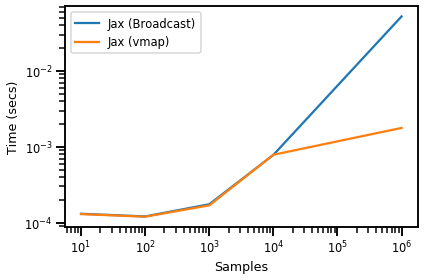

In [71]:
fig, ax = plt.subplots()
ax.plot(n_samples, times['jax_mu'], label='Jax (Broadcast)')
ax.plot(n_samples, times['vmap_mu'], label='Jax (vmap)')
ax.set(yscale='log', xscale='log', xlabel="Samples", ylabel="Time (secs)")
plt.legend()
plt.tight_layout()
plt.show()

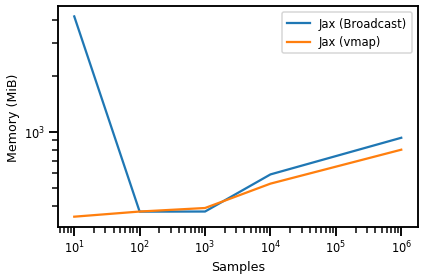

In [72]:
fig, ax = plt.subplots()
ax.plot(n_samples, memories['jax_mu'], label='Jax (Broadcast)')
ax.plot(n_samples, memories['vmap_mu'], label='Jax (vmap)')
ax.set(yscale='log', xscale='log', xlabel="Samples", ylabel="Memory (MiB)")
plt.legend()
plt.tight_layout()
plt.show()

## KDE CDF

In [347]:
@jax.jit
def broadcast_kde_pdf(eval_points, samples, bandwidth):
    
    # distances (use broadcasting)
    rescaled_x = (eval_points[:, np.newaxis] - samples[np.newaxis, :])  / bandwidth #(2 * bandwidth ** 2)
    
    # compute the gaussian kernel
    gaussian_kernel = 1 / np.sqrt(2 * np.pi)  * np.exp(- 0.5 * rescaled_x ** 2 ) 
    
    # rescale
    return gaussian_kernel.sum(axis=1) / samples.shape[0] / bandwidth

@jax.jit
def batch_kde(eval_points, samples, bandwidth):
    
    # distances (use broadcasting)
    rescaled_x = (eval_points - samples) / bandwidth
    
    # compute the gaussian kernel
    gaussian_kernel = np.exp(- 0.5 * rescaled_x ** 2) / np.sqrt(2 * np.pi) 
    
    # rescale
    return gaussian_kernel.sum(axis=0) / samples.shape[0] / bandwidth

In [348]:
n_samples = 10_000

x = np.sort(data[:, 1])
xi = np.linspace(-2, 2, n_samples)
xi = x #np.sort(xi)

(100,)


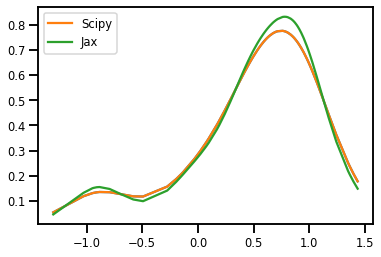

In [349]:
kde_model = stats.gaussian_kde(onp.array(x), bw_method='silverman')

x_pdf = kde_model.pdf(onp.array(xi))

plt.figure()
plt.plot(xi, x_pdf)
plt.plot(xi, x_pdf, label='Scipy')
bw = scotts_method(x.shape[0], 1)
x_pdf = broadcast_kde_pdf(xi, x, .5 * bw)
print(x_pdf.shape)
# x_pdf = jax.vmap(batch_kde, in_axes=(0, None, None))(xi, x, bw)
plt.plot(xi, x_pdf, label='Jax')
plt.legend()
plt.show()

In [350]:
print(kde_model.factor)

0.42168460634274996


In [310]:
cdf_f = onp.vectorize(lambda x: kde_model.integrate_box_1d(-np.inf, x))

x_cdf_sci = cdf_f(onp.array(xi))



In [311]:


def normalization_factor(data, bw):
    
    data_covariance = np.cov(data[:, np.newaxis], rowvar=0, bias=False)
    
    covariance = data_covariance * bw ** 2
    
    stdev = np.sqrt(covariance)
    
    return stdev

In [312]:
def broadcast_kde_cdf(x_eval, samples, factor):
    return jax.scipy.special.ndtr((x_eval[:, np.newaxis] - samples[np.newaxis, :])/factor).mean(axis=1)

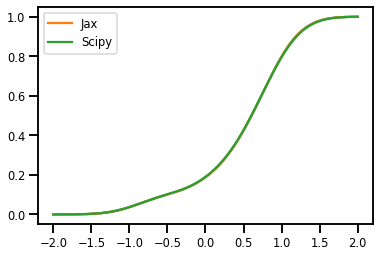

In [313]:
x_cdf = broadcast_kde_cdf(xi, x, factor)
plt.plot(xi, x_cdf)
plt.plot(xi, x_cdf, label='Jax')
plt.plot(xi, x_cdf_sci, label='Scipy')
plt.legend()
plt.show()

In [ ]:
%timeit broadcast_kde_cdf(x_eval, x, factor)

In [335]:
def kde_cdf(x_eval, samples, factor):
    
    low = np.ravel((-np.inf - samples ) / factor)
    hi = np.ravel((x_eval - samples) / factor)
    return jax.scipy.special.ndtr(hi - low).mean(axis=0)

In [ ]:
%timeit 

In [336]:
factor = normalization_factor(x, 0.3)
x_cdf = jax.vmap(kde_cdf, in_axes=(0, None, None))(x_eval, x, factor)

In [92]:
%timeit jax.vmap(kde_cdf, in_axes=(0, None, None))(x_eval, x, factor)

627 ms ± 9.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


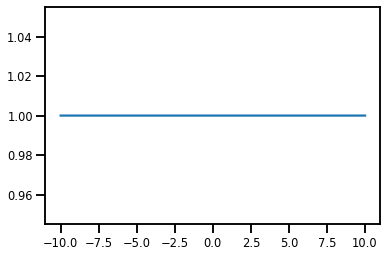

In [337]:
plt.plot(x_eval, x_cdf)

In [120]:

x_eval = np.linspace(-2.0, 2.0, 100)
x_pdf = batched_kde(x_eval)

data = x 
sample = np.array([x_eval[100]])
n_samples = x.shape[0]

In [118]:





scotts_factor = 0.2
covariance_factor = scotts_factor
factor = covariance_factor
data_covariance = np.cov(data[:, np.newaxis], rowvar=0, bias=False)

covariance = data_covariance * factor ** 2

# scipy implementation
stdev = np.sqrt(covariance)

# normalized_low = np.ravel((-np.inf - data) / stdev)
# normalized_high = np.ravel((sample - data) / stdev)

# value = np.mean(
#     jax.scipy.special.ndtr(normalized_high) -
#     jax.scipy.special.ndtr(normalized_low)
# )

# # subtraction

x_cdf = jax.scipy.special.ndtr((x_eval[:, np.newaxis] - data[np.newaxis, :])/stdev).mean(axis=1)



In [116]:
data_covariance = np.cov(data[np.newaxis, :], rowvar=1, bias=False)
data_covariance

DeviceArray(0.36420813, dtype=float32)

In [92]:
normalized_high.shape

(100,)

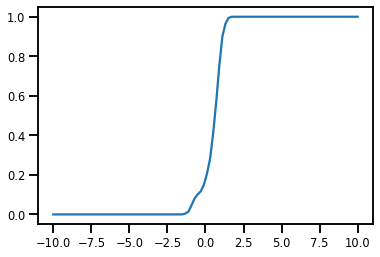

In [117]:
plt.plot(x_eval, x_cdf)

In [ ]:
data_inv_cov = np.linalg.inv(data_covariance)
inv_cov = data_inv_cov / factor ** 2
norm_factor = np.sqrt(np.linalg.det(2 * np.pi * covariance))

In [ ]:



plt.plot(x_eval, x_pdf)

In [71]:
t = onp.subtract.outer(x_eval, data)
t2 = x_eval[:, np.newaxis] - data[np.newaxis, :]

In [72]:
onp.testing.assert_array_equal(t, t2)

In [68]:
np.outer(x_eval, data)

AttributeError: 'function' object has no attribute 'outer'